<a href="https://www.kaggle.com/code/khinguyntin/mri-lightweighted-gan?scriptVersionId=243855628" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# -*- coding: utf-8 -*-
"""
wgan_gp_mri_distillation_moe_128px.py - EXTENDED (30 Epochs, Upgraded Models, Early Stopping)

Huấn luyện WGAN-GP lớn (Teacher), chưng cất kiến thức sang WGAN-GP nhỏ (Student).
Tạo ảnh MRI NIfTI 128x128. Bao gồm lọc file lỗi, loại bỏ nền,
hiển thị ảnh qua từng epoch, và đánh giá bằng FID, IS, VoL.
Chạy thử nghiệm với 30 epochs cho mỗi model, với khả năng early stopping.
"""

# ==================================
# Phần 1: Cài đặt và Nhập thư viện
# ==================================
import os
import glob
import random
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torchsummary import summary
import logging
import imageio.v2 as imageio
from scipy.ndimage import laplace, binary_opening, binary_closing, label, find_objects
from skimage.filters import threshold_otsu
import gc
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import Image as IPImage, display as IPdisplay

import torchvision.models as models
from scipy import linalg

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [2]:
# ==================================
# Phần 2: Thiết lập và Cấu hình
# ==================================
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

common_config = {
    "dataset_slug": "mri-not-skull-stripped",
    "base_data_folder": "",
    "checkpoint_dataset_slug": None,
    "workers": 2,
    "batch_size": 16,  
    "image_size": 128,
    "nc": 1,
    "nz": 100,
    "slice_axis": 2,
    "slice_percentile_range": (0.4, 0.6),
    "background_threshold_scale": 0.15,
    "ngpu": 1,
    "c_lambda": 10,
    "crit_repeats": 5,
    "display_log_step": 50,  
    "save_image_iters_step": 0,  
    "display_image_epoch_end": True,
    "lr_decay_gamma": 0.98,
    "num_eval_samples": 256,
    "image_grid_padding": 4,
    "save_checkpoint_epochs": 5,  
    # Early Stopping Parameters
    "early_stopping_patience": 5,  
    "early_stopping_min_delta": 0.001,  
    "enable_early_stopping": True,
}

config_teacher = {
    **common_config,
    "model_type": "Teacher (Upgraded 128px)",
    "ngf": 96, "ndf": 96,  
    "num_epochs": 30,      
    "lr_g": 0.0001, "lr_c": 0.15,
    "beta1": 0.0, "beta2": 0.9,
    "output_dir": "/kaggle/working/output_wgan_gp_teacher_128px_30epochs"
}

config_student = {
    **common_config,
    "model_type": "Student (Upgraded KD 128px)",
    "ngf": 32, "ndf": 32, 
    "num_epochs": 30,    
    "lr_g": 0.0001, "lr_c": 0.00015,
    "beta1": 0.0, "beta2": 0.9,
    "kd_lambda": 0.5,
    "output_dir": "/kaggle/working/output_wgan_gp_student_kd_128px_30epochs"
}

os.makedirs(config_teacher["output_dir"], exist_ok=True)
os.makedirs(config_student["output_dir"], exist_ok=True)
logging.info(
    f"Output dirs created: Teacher: {config_teacher['output_dir']}, "
    f"Student: {config_student['output_dir']}"
)

CHECKPOINT_BASE_DIR_FROM_DATASET = (
    f"/kaggle/input/{common_config['checkpoint_dataset_slug']}/"
    if common_config.get('checkpoint_dataset_slug') else None
)

In [3]:
# ==================================
# Phần 3: Thiết lập Thiết bị
# ==================================
device = torch.device("cuda:0" if torch.cuda.is_available() and common_config["ngpu"] > 0 else "cpu")
if device.type == 'cuda':
    torch.cuda.set_device(device)
    logging.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    logging.info("Using CPU")

Filtering NIfTI files: 100%|██████████| 20550/20550 [01:57<00:00, 175.55it/s]


Variance of Laplacian for the sample batch: 13120.7042


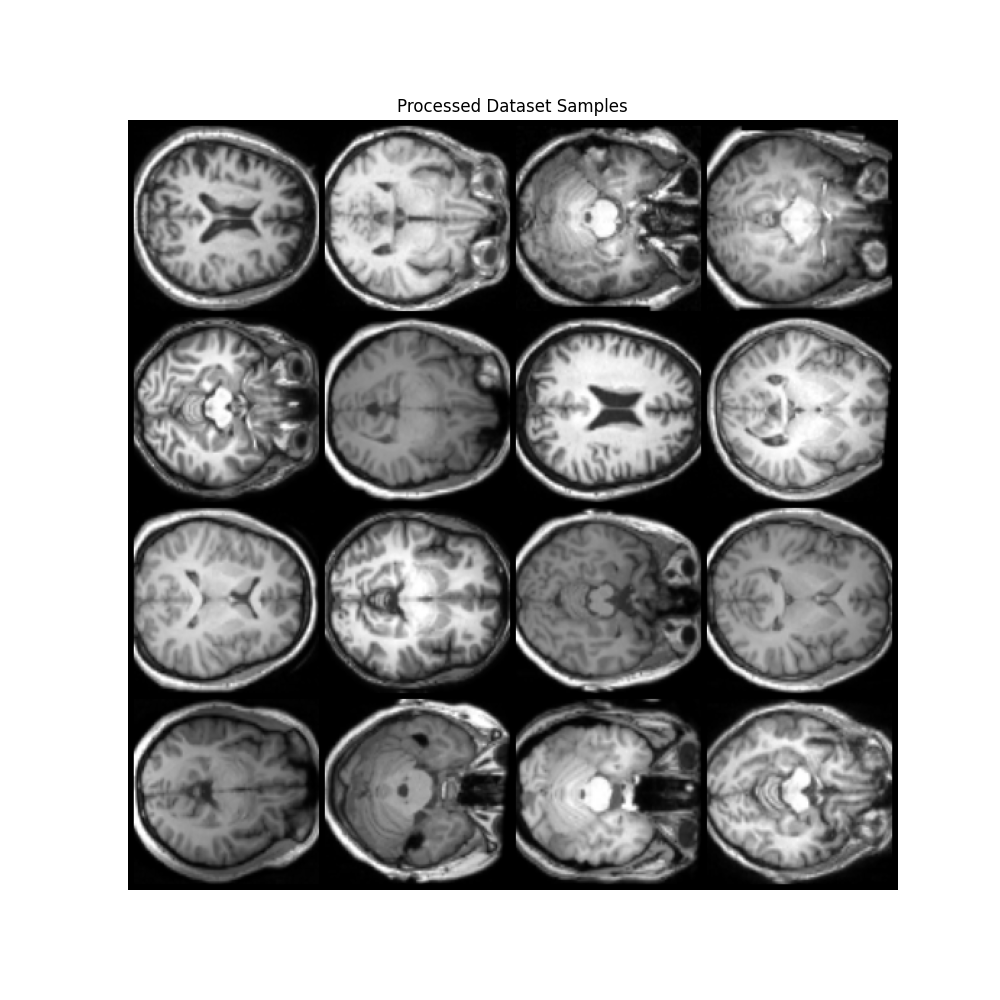

In [5]:
# ==================================
# Phần 4: Dataset, Transforms, DataLoader
# ==================================
class MRIDataset(Dataset):
    def __init__(self, data_dir, img_size, slice_axis=2,
                 slice_percentile_range=(0.45, 0.55),
                 transform=None, background_threshold_scale=0.1):
        self.data_dir = data_dir
        self.img_size = img_size
        self.slice_axis = slice_axis
        self.slice_percentile_range = slice_percentile_range
        self.transform = transform
        self.background_threshold_scale = background_threshold_scale

        patterns_to_try = [
            'sub-*/anat/sub-*_T1w.nii.gz', 'sub-*/anat/sub-*_T1w.nii',
            'sub-*/ses-*/anat/sub-*_ses-*_T1w.nii.gz', 'sub-*/ses-*/anat/sub-*_ses-*_T1w.nii',
            'sub-*/anat/sub-*_T1w.nii/sub-*_T1w.nii*',
            '*.nii.gz', '*.nii'
        ]
        all_found_files = []
        is_kaggle_path = data_dir.startswith('/kaggle/input/')

        if not os.path.exists(data_dir) and not is_kaggle_path:
            logging.warning(
                f"Dataset directory {data_dir} does not exist for local run. "
                "Attempting to use/create dummy data."
            )
            self.file_paths = []
            self.num_files = 0
            dummy_data_folder = "dummy_mri_data_extended"
            if not os.path.exists(dummy_data_folder):
                os.makedirs(dummy_data_folder)
            dummy_nii_path = os.path.join(dummy_data_folder, "dummy_scan.nii.gz")

            if not os.path.exists(dummy_nii_path):
                try:
                    dummy_data_arr = np.random.rand(64, 64, 30).astype(np.float32) * 1000
                    dummy_nii_img = nib.Nifti1Image(dummy_data_arr, np.eye(4))
                    nib.save(dummy_nii_img, dummy_nii_path)
                    logging.info(f"Created dummy NIfTI file: {dummy_nii_path}")
                    self.file_paths.append(dummy_nii_path)
                    self.num_files = 1
                except Exception as e_dummy:
                    logging.error(f"Could not create dummy NIfTI: {e_dummy}")
            elif os.path.exists(dummy_nii_path):
                 self.file_paths.append(dummy_nii_path)
                 self.num_files = 1

            if not self.file_paths:
                logging.error("CRITICAL: No NIfTI files and dummy creation failed.")
                return
        else:
            for p in patterns_to_try:
                all_found_files.extend(glob.glob(os.path.join(data_dir, '**', p), recursive=True))
                all_found_files.extend(glob.glob(os.path.join(data_dir, p)))

            all_found_files = sorted(list(set(all_found_files)))
            if not all_found_files:
                logging.error(f"CRITICAL: No NIfTI files found in {data_dir} with patterns.")
                self.file_paths = []
                self.num_files = 0
                return

            logging.info(f"Found {len(all_found_files)} potential NIfTI files. Filtering...")
            self.file_paths = []
            corrupted_files_count = 0
            skipped_log_count = 0
            max_skipped_logs_to_display = 5

            for file_path in tqdm(all_found_files, desc="Filtering NIfTI files"):
                try:
                    if os.path.getsize(file_path) < 1024:
                        if skipped_log_count < max_skipped_logs_to_display:
                            logging.debug(f"Skipping small: {file_path}")
                        skipped_log_count += 1
                        corrupted_files_count += 1
                        continue
                    img_nii = nib.load(file_path, mmap=False)
                    _ = img_nii.shape
                    self.file_paths.append(file_path)
                except Exception as e:
                    if skipped_log_count < max_skipped_logs_to_display:
                        logging.debug(f"Skipping corrupted {file_path}: {e}")
                    skipped_log_count += 1
                    corrupted_files_count += 1

            if corrupted_files_count > 0:
                logging.warning(f"Skipped {corrupted_files_count} potentially corrupted or small files.")
            if not self.file_paths:
                logging.error("CRITICAL: No valid NIfTI files left after filtering.")
                self.num_files = 0
                return
            self.num_files = len(self.file_paths)

        logging.info(f"Dataset: {self.num_files} valid files.")

    def __len__(self):
        return self.num_files

    def remove_background_and_crop(self, slice_img_normalized):
        try:
            thresh_val = threshold_otsu(slice_img_normalized)
            final_thresh = max(thresh_val * self.background_threshold_scale, 0.05)
            binary_mask = slice_img_normalized > final_thresh
        except Exception:
            if slice_img_normalized.max() == 0:
                binary_mask = np.zeros_like(slice_img_normalized, dtype=bool)
            else:
                binary_mask = slice_img_normalized > np.percentile(
                    slice_img_normalized[slice_img_normalized > 0.01], 10
                )

        opened_mask = binary_opening(binary_mask, iterations=2)
        closed_mask = binary_closing(opened_mask, iterations=2)
        labeled_mask, num_features = label(closed_mask)

        if num_features > 0:
            component_sizes = np.bincount(labeled_mask.ravel())
            if len(component_sizes) > 1:
                largest_component_label = component_sizes[1:].argmax() + 1
                final_mask = (labeled_mask == largest_component_label)
            else:
                final_mask = np.zeros_like(slice_img_normalized, dtype=bool)
        else:
            final_mask = np.zeros_like(slice_img_normalized, dtype=bool)

        if np.any(final_mask):
            obj = find_objects(final_mask)
            if obj and obj[0] is not None:
                 y_slice, x_slice = obj[0]
                 return slice_img_normalized[y_slice.start:y_slice.stop, x_slice.start:x_slice.stop]
        return slice_img_normalized

    def __getitem__(self, idx):
        if not self.file_paths:
            return torch.zeros((common_config["nc"], self.img_size, self.img_size))

        file_path = self.file_paths[idx]
        slice_idx_val = "N/A"
        try:
            img_nii = nib.load(file_path, mmap=False)
            img_data = img_nii.get_fdata(dtype=np.float32)

            min_p, max_p_r = self.slice_percentile_range
            rand_p = random.uniform(min_p, max_p_r)
            slice_idx_val = np.clip(
                int(img_data.shape[self.slice_axis] * rand_p),
                0,
                img_data.shape[self.slice_axis] - 1
            )

            if self.slice_axis == 0:
                sl_img = img_data[slice_idx_val, :, :]
            elif self.slice_axis == 1:
                sl_img = img_data[:, slice_idx_val, :]
            else:
                sl_img = img_data[:, :, slice_idx_val]

            valid_pixels = sl_img[sl_img > (np.min(sl_img) + 1e-6)]
            if valid_pixels.size > 100:
                p_l, p_h = np.percentile(valid_pixels, [1, 99])
            else:
                p_l, p_h = np.min(sl_img), np.max(sl_img)

            if p_l >= p_h:
                p_l, p_h = np.min(sl_img), np.max(sl_img)

            sl_clip = np.clip(sl_img, p_l, p_h)
            sl_norm = (sl_clip - p_l) / (p_h - p_l + 1e-6)
            cr_sl = self.remove_background_and_crop(sl_norm)

            final_slice_to_transform = (
                cr_sl if (cr_sl.size > 0 and cr_sl.shape[0] >= 10 and cr_sl.shape[1] >= 10)
                else sl_norm
            )

            t_in = torch.from_numpy(final_slice_to_transform.copy()).unsqueeze(0).float()
            if self.transform:
                t_in = self.transform(t_in)
            return t_in
        except Exception as e:
            logging.error(
                f"Lỗi xử lý file {file_path} (slice_idx {slice_idx_val}): {e}. "
                "Trả về tensor zero."
            )
            return torch.zeros((common_config["nc"], self.img_size, self.img_size))

transform_mri = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(
        (common_config["image_size"], common_config["image_size"]),
        antialias=True
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

base_dataset_path = (
    f'/kaggle/input/{common_config["dataset_slug"]}/{common_config["base_data_folder"]}'
    .rstrip('/')
)

if not common_config["base_data_folder"]:
    if base_dataset_path.startswith('/kaggle/input/'):
        base_dataset_path = f'/kaggle/input/{common_config["dataset_slug"]}'
    else:
        base_dataset_path = f'./{common_config["dataset_slug"]}'
        if not os.path.exists(base_dataset_path) and os.path.exists("./dummy_mri_data_extended"):
             base_dataset_path = "./dummy_mri_data_extended"

dataset_mri = MRIDataset(
    data_dir=base_dataset_path,
    img_size=common_config["image_size"],
    slice_axis=common_config["slice_axis"],
    slice_percentile_range=common_config["slice_percentile_range"],
    transform=transform_mri,
    background_threshold_scale=common_config.get("background_threshold_scale", 0.15)
)

dataloader_mri = None
if dataset_mri.num_files > 0:
    dataloader_mri = DataLoader(
        dataset_mri,
        batch_size=common_config["batch_size"],
        shuffle=True,
        num_workers=common_config["workers"],
        pin_memory=True,
        drop_last=True
    )
    logging.info(
        f"DataLoader: {len(dataset_mri)} samples, "
        f"{len(dataloader_mri)} batches/epoch."
    )
    try:
        logging.info("Visualizing dataset samples...")
        sample_batch = next(iter(dataloader_mri))
        vol_score = calculate_vol(sample_batch)
        print(f"Variance of Laplacian for the sample batch: {vol_score:.4f}")
        fig_ds, ax_ds = plt.subplots(figsize=(10, 10))
        ax_ds.axis("off")
        ax_ds.set_title("Processed Dataset Samples")
        grid_img_ds = vutils.make_grid(
            sample_batch[:min(common_config["batch_size"], 16)].cpu(),
            padding=common_config["image_grid_padding"],
            normalize=True,
            nrow=4
        )
        ax_ds.imshow(grid_img_ds.permute(1, 2, 0).squeeze(), cmap='gray')
        sample_vis_path_ds = os.path.join(
            config_teacher["output_dir"],
            "dataset_processed_samples_grid.png"
        )
        plt.savefig(sample_vis_path_ds)
        logging.info(f"Dataset sample viz saved: {sample_vis_path_ds}")
        if IPImage is not None:
            IPdisplay(IPImage(sample_vis_path_ds))
        plt.close(fig_ds)
    except Exception as e:
        logging.error(f"Dataset viz error: {e}")
else:
    logging.error("Dataset empty or path incorrect. DataLoader not created. Training skipped.")

In [4]:
# ==================================
# Phần 5: Hàm Tiện ích & Checkpoint
# ==================================
def weights_init(m):
    cn = m.__class__.__name__
    if cn.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif cn.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def get_noise(n_s, nz_dim, dev):
    return torch.randn(n_s, nz_dim, 1, 1, device=dev)

def gradient_penalty(grad):
    grad = grad.view(len(grad), -1)
    gn = grad.norm(2, dim=1)
    return torch.mean((gn - 1)**2)

def get_gradient(cr, rl, fk, eps):
    mx_img = rl * eps + fk * (1 - eps)
    mx_scr = cr(mx_img)
    return torch.autograd.grad(
        inputs=mx_img,
        outputs=mx_scr,
        grad_outputs=torch.ones_like(mx_scr),
        create_graph=True,
        retain_graph=True
    )[0]

def get_gen_loss(cr_fk_pred):
    return -torch.mean(cr_fk_pred)

def get_crit_loss(cr_fk_pred, cr_rl_pred, gp_val, c_lam):
    return torch.mean(cr_fk_pred) - torch.mean(cr_rl_pred) + c_lam * gp_val

def display_and_save_tensor_images(
    image_tensor: torch.Tensor,
    output_dir: str,
    model_type_str: str,
    epoch_num: int,
    iteration_num: int,
    num_images_to_display: int = 16,
    nrow_display: int = 4,
    img_size_tuple: tuple = (1, 128, 128),
    save_fig_flag: bool = True,
    show_fig_in_notebook: bool = False,
    grid_padding: int = 2
):
    filepath = None
    try:
        img_unflat = image_tensor.detach().cpu().view(-1, *img_size_tuple)
        base_title = (
            f"{model_type_str.replace(' ','_').replace('(','').replace(')','').replace('+','plus').replace('px','').replace('student_experts','se')}"
            "_Gen"
        )
        disp_title = f"{base_title}_Ep{epoch_num}_It{iteration_num}"
        imgs_grid = img_unflat[:num_images_to_display]
        img_grid_tensor = vutils.make_grid(
            imgs_grid,
            nrow=nrow_display,
            normalize=True,
            padding=grid_padding
        )
        fig_disp, ax_disp = plt.subplots(figsize=(8, 8))
        ax_disp.axis('off')
        ax_disp.set_title(disp_title)
        ax_disp.imshow(img_grid_tensor.permute(1, 2, 0).squeeze(), cmap='gray')

        if save_fig_flag or show_fig_in_notebook:
            fname = f'img_{base_title.lower()}_ep{epoch_num:03d}_it{iteration_num:06d}.png'
            filepath = os.path.join(output_dir, fname)
            plt.savefig(filepath, bbox_inches='tight')
            if show_fig_in_notebook and IPImage is not None:
                IPdisplay(IPImage(filepath))
        plt.close(fig_disp)
    except Exception as e:
        logging.error(
            f"Err disp/save img {model_type_str} E{epoch_num} I{iteration_num}: {e}"
        )
    return filepath

def plot_losses(g_ls, c_ls, out_dir, fname, m_type, start_iter=0):
    if not g_ls and not c_ls:
        logging.warning(f"Không có dữ liệu loss để vẽ cho {m_type}.")
        return

    iters_g = np.arange(start_iter, start_iter + len(g_ls))
    iters_c = np.arange(start_iter, start_iter + len(c_ls))

    plt.figure(figsize=(12, 6))
    plt.title(f"{m_type} G & C Losses (Từ iter {start_iter})")
    if g_ls:
        plt.plot(iters_g, g_ls, label="G Loss")
    if c_ls:
        plt.plot(iters_c, c_ls, label="C Loss")
    plt.xlabel("Tổng số Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plot_path = os.path.join(out_dir, fname)
    plt.savefig(plot_path)
    plt.close()
    logging.info(f"Đã lưu biểu đồ loss tới {plot_path}")
    if IPImage is not None:
        IPdisplay(IPImage(plot_path))

def calculate_vol(imgs_b):
    if not isinstance(imgs_b, torch.Tensor) or not imgs_b.numel():
        return 0.0

    lap_vars = []
    for img_t in imgs_b:
        img_n = img_t.squeeze().cpu().numpy()
        if img_n.ndim > 2:
            img_n = img_n[0]
        if img_n.ndim != 2:
            logging.warning(f"VoL: Bỏ qua ảnh có ndim {img_n.ndim}")
            continue
        if img_n.max() <= img_n.min() + 1e-6:
            lap_vars.append(0.0)
            continue
        img_u8 = (( (img_n - img_n.min()) / (img_n.max() - img_n.min() + 1e-6) ) * 255).astype(np.uint8)
        lap_vars.append(laplace(img_u8).var())
    return np.mean(lap_vars) if lap_vars else 0.0

def save_full_checkpoint(overall_epoch, model, optimizer, scheduler,
                         loss_g_hist, loss_c_hist, path):
    torch.save({
        'epoch': overall_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss_g_history': loss_g_hist,
        'loss_c_history': loss_c_hist,
    }, path)
    logging.info(
        f"Đã lưu checkpoint đầy đủ tới {path} tại epoch hoàn thành {overall_epoch}"
    )

def load_full_checkpoint(model, optimizer, scheduler, model_path, device_load="cpu"):
    start_epoch_to_run = 0
    loaded_loss_g, loaded_loss_c = [], []
    if os.path.exists(model_path):
        logging.info(f"Đang tải checkpoint từ: {model_path}")
        try:
            checkpoint = torch.load(model_path, map_location=device_load, weights_only=True)
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer and 'optimizer_state_dict' in checkpoint and checkpoint['optimizer_state_dict']:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            if 'epoch' in checkpoint:
                start_epoch_to_run = checkpoint['epoch'] + 1
            if 'loss_g_history' in checkpoint:
                loaded_loss_g = checkpoint['loss_g_history']
            if 'loss_c_history' in checkpoint:
                loaded_loss_c = checkpoint['loss_c_history']
            logging.info(
                f"Đã tải model thành công (weights_only=True). "
                f"Tiếp tục từ epoch {start_epoch_to_run}."
            )
            return start_epoch_to_run, loaded_loss_g, loaded_loss_c
        except (RuntimeError, KeyError) as e_runtime:
            logging.warning(
                f"Lỗi khi tải checkpoint với weights_only=True ({e_runtime}). "
                "Thử với weights_only=False."
            )
            try:
                checkpoint = torch.load(model_path, map_location=device_load, weights_only=False) # Fallback
                model.load_state_dict(checkpoint['model_state_dict'])
                if optimizer and 'optimizer_state_dict' in checkpoint and checkpoint['optimizer_state_dict']:
                    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                if 'epoch' in checkpoint:
                    start_epoch_to_run = checkpoint['epoch'] + 1
                if 'loss_g_history' in checkpoint:
                    loaded_loss_g = checkpoint['loss_g_history']
                if 'loss_c_history' in checkpoint:
                    loaded_loss_c = checkpoint['loss_c_history']
                logging.info(
                    f"Đã tải model thành công (weights_only=False). "
                    f"Tiếp tục từ epoch {start_epoch_to_run}."
                )
                return start_epoch_to_run, loaded_loss_g, loaded_loss_c
            except Exception as e_fallback:
                logging.error(
                    f"Lỗi khi tải checkpoint (weights_only=False) từ {model_path}: {e_fallback}. "
                    "Thử tải chỉ trọng số."
                )
                try: # Try loading only state_dict with weights_only=True
                    model.load_state_dict(
                        torch.load(model_path, map_location=device_load, weights_only=True)['model_state_dict']
                    )
                    logging.info("Đã tải chỉ trọng số model (weights_only=True).")
                except: # Final fallback: state_dict with weights_only=False
                    try:
                        model.load_state_dict(
                            torch.load(model_path, map_location=device_load, weights_only=False)['model_state_dict']
                        )
                        logging.info("Đã tải chỉ trọng số model (weights_only=False).")
                    except Exception as e_nested:
                        logging.error(f"Không thể tải chỉ trọng số từ {model_path}: {e_nested}.")
                return 0, [], [] # Start fresh if only state_dict loaded
        except Exception as e_general: # Catch other general exceptions
            logging.error(
                f"Lỗi chung khi tải checkpoint từ {model_path}: {e_general}. "
                "Thử tải chỉ trọng số."
            )
            # Same fallback logic as above for state_dict only
            try:
                model.load_state_dict(
                    torch.load(model_path, map_location=device_load, weights_only=True)['model_state_dict']
                )
                logging.info("Đã tải chỉ trọng số model (weights_only=True).")
            except:
                try:
                    model.load_state_dict(
                        torch.load(model_path, map_location=device_load, weights_only=False)['model_state_dict']
                    )
                    logging.info("Đã tải chỉ trọng số model (weights_only=False).")
                except Exception as e_nested:
                    logging.error(f"Không thể tải chỉ trọng số từ {model_path}: {e_nested}.")
            return 0, [], []
    return 0, [], []

def find_latest_checkpoint_file(base_dir_list, model_prefix,
                                model_output_folder_name, config_num_epochs):
    latest_overall_epoch = -1
    chosen_file_path = None

    for base_dir in base_dir_list:
        if base_dir is None or not os.path.isdir(base_dir):
            continue
        checkpoint_dir = os.path.join(base_dir, model_output_folder_name)
        if not os.path.isdir(checkpoint_dir):
            continue

        final_checkpoint_path = os.path.join(checkpoint_dir, f"{model_prefix}_final.pt")
        if os.path.exists(final_checkpoint_path):
            try:
                ckpt_data = torch.load(final_checkpoint_path, map_location='cpu', weights_only=True)
                if isinstance(ckpt_data, dict) and 'epoch' in ckpt_data:
                    if ckpt_data['epoch'] == config_num_epochs - 1:
                         if ckpt_data['epoch'] > latest_overall_epoch:
                             latest_overall_epoch = ckpt_data['epoch']
                             chosen_file_path = final_checkpoint_path
                elif isinstance(ckpt_data, dict) and 'model_state_dict' in ckpt_data:
                    # If it's just a state dict, assume it's the final one for num_epochs
                    if config_num_epochs - 1 > latest_overall_epoch:
                        latest_overall_epoch = config_num_epochs - 1
                        chosen_file_path = final_checkpoint_path
            except Exception as e:
                logging.warning(
                    f"Không thể đọc epoch từ file final {final_checkpoint_path} "
                    f"(weights_only=True): {e}"
                )

        epoch_files = glob.glob(os.path.join(checkpoint_dir, f"{model_prefix}_ep*.pt"))
        for f_path in epoch_files:
            try:
                epoch_num_str = os.path.basename(f_path).split('_ep')[-1].split('.pt')[0]
                current_file_epoch = int(epoch_num_str) - 1 # epoch in filename is 1-based
                if current_file_epoch > latest_overall_epoch:
                    latest_overall_epoch = current_file_epoch
                    chosen_file_path = f_path
            except ValueError:
                continue # Skip files not matching the epoch pattern
    return chosen_file_path, latest_overall_epoch

# Cosine angle-based selector with EMA gradient history
def select_param_by_angle(model: nn.Module, grad_history: dict, update_ratio: float, ema_alpha: float = 0.7) -> set:
    scores_list = []
    param_names = []
    
    any_scores_computed = False # Flag to track if we successfully computed a score

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        # In this optimized setup, param.grad will only be populated after a full backward.
        # If it's a selective batch, param.grad will be None.
        # We only use param.grad here during "full update" batches for history.
        if param.grad is None:
            continue # Can't score if no grad.

        current_grad = param.grad.detach().cpu().clone() # Detach, move to CPU, clone

        if name not in grad_history or not grad_history[name]:
            # This is the first time we see this parameter with a gradient.
            # Initialize its history with the current gradient. No score can be computed yet.
            grad_history[name] = [current_grad]
        else:
            prev_ema_grad = grad_history[name][0]
            # Update EMA history with the current gradient
            new_ema_grad = ema_alpha * prev_ema_grad + (1 - ema_alpha) * current_grad
            grad_history[name][0] = new_ema_grad

            # Calculate cosine similarity using the previous EMA gradient and the new current gradient
            g1 = prev_ema_grad.view(-1)
            g2 = current_grad.view(-1)

            if g1.norm() > 0 and g2.norm() > 0:
                cos_sim = F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()
                angle_score = 1 - cos_sim # Higher score for larger angle (more change)
            else:
                angle_score = 1.0 # Default score if one/both gradients are zero

            scores_list.append(angle_score)
            param_names.append(name)
            any_scores_computed = True # Successfully computed a score

    if not any_scores_computed:
        # Fallback: If no scores could be computed (e.g., very first full update batch,
        # or all grads were zero/no history), return all trainable parameters to ensure updates.
        return {name for name, p in model.named_parameters() if p.requires_grad}

    scores_tensor = torch.tensor(scores_list, device='cpu')
    top_k = max(1, int(update_ratio * len(scores_list)))
    _, top_indices = torch.topk(scores_tensor, k=top_k, largest=True, sorted=False)

    selected_names = set()
    for idx in top_indices:
        selected_names.add(param_names[idx])
    return selected_names

In [ ]:
# ==================================
# Phần 6: Model Definitions
# ==================================
class BaseGenerator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g_base,
                 num_upsample_blocks, target_img_size):
        super().__init__()
        initial_out_channels = features_g_base * (2**num_upsample_blocks)
        layers = [
            self._block(z_dim, initial_out_channels, kernel_size=4, stride=1, padding=0)
        ]
        current_size = 4
        in_feat = initial_out_channels
        while current_size < target_img_size / 2:
            out_feat = max(in_feat // 2, features_g_base)
            layers.append(self._block(in_feat, out_feat, kernel_size=4, stride=2, padding=1))
            in_feat = out_feat
            current_size *= 2
        layers.append(
            nn.ConvTranspose2d(in_feat, img_channels, kernel_size=4, stride=2, padding=1)
        )
        layers.append(nn.Tanh())
        self.gen = nn.Sequential(*layers)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.gen(x)

class Generator_Teacher(BaseGenerator):
    def __init__(self, z_dim, img_channels, features_g, target_img_size):
        n_upsample_factor = int(np.log2(target_img_size / 8)) if target_img_size >= 8 else 0
        super().__init__(
            z_dim, img_channels, features_g,
            num_upsample_blocks=n_upsample_factor,
            target_img_size=target_img_size
        )

class Generator_Student(BaseGenerator):
    def __init__(self, z_dim, img_channels, features_g, target_img_size):
        n_upsample_factor = int(np.log2(target_img_size / 8)) if target_img_size >= 8 else 0
        super().__init__(
            z_dim, img_channels, features_g,
            num_upsample_blocks=n_upsample_factor,
            target_img_size=target_img_size
        )

class BaseCritic(nn.Module):
    def __init__(self, img_channels, features_d_base, input_img_size, use_resnet_blocks=False):
        super().__init__()
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.use_resnet_blocks = use_resnet_blocks
        layers = []
        in_c = img_channels
        num_downsample_blocks = 0
        temp_size = input_img_size
        while temp_size > 4:
            temp_size //= 2
            num_downsample_blocks += 1

        current_f = features_d_base
        if use_resnet_blocks:
            layers.append(
                self._make_res_block(in_c, current_f, stride=2, use_norm_shortcut_init=False)
            )
        else:
            layers.append(
                self._make_conv_block(in_c, current_f, stride=2, use_norm=False)
            )
        in_c = current_f

        for _ in range(num_downsample_blocks - 1):
            out_c = min(in_c * 2, features_d_base * 16)
            if use_resnet_blocks:
                layers.append(
                    self._make_res_block(in_c, out_c, stride=2, use_norm_shortcut_init=True)
                )
            else:
                layers.append(
                    self._make_conv_block(in_c, out_c, stride=2, use_norm=True)
                )
            in_c = out_c

        final_map_size = input_img_size // (2**num_downsample_blocks)
        layers.append(nn.Conv2d(in_c, 1, kernel_size=final_map_size, stride=1, padding=0))

        self.critic_network = nn.ModuleList(layers) if use_resnet_blocks else nn.Sequential(*layers)

    def _make_conv_block(self, in_ch, out_ch, stride, use_norm):
        block_layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1, bias=not use_norm)
        ]
        if use_norm:
            block_layers.append(nn.InstanceNorm2d(out_ch, affine=True))
        block_layers.append(self.relu)
        return nn.Sequential(*block_layers)

    def _make_res_block(self, in_ch, out_ch, stride, use_norm_shortcut_init=True):
        main_path = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            self.relu,
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True)
        )
        shortcut_path = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            conv_shortcut = nn.Conv2d(
                in_ch, out_ch, kernel_size=1, stride=stride, padding=0, bias=False
            )
            if use_norm_shortcut_init:
                shortcut_path = nn.Sequential(conv_shortcut, nn.InstanceNorm2d(out_ch, affine=True))
            else:
                shortcut_path = nn.Sequential(conv_shortcut)
        return nn.ModuleDict({'main': main_path, 'shortcut': shortcut_path})

    def forward(self, x):
        out = x
        if self.use_resnet_blocks:
            for i, layer_module in enumerate(self.critic_network):
                if isinstance(layer_module, nn.ModuleDict):
                    main_out = layer_module['main'](out)
                    shortcut_out = layer_module['shortcut'](out)
                    out = main_out + shortcut_out
                    if i < len(self.critic_network) - 1: # Apply ReLU for intermediate blocks
                        out = self.relu(out)
                else: # The final Conv2d layer
                    out = layer_module(out)
            return out.view(out.size(0), -1) # Flatten for loss calculation
        else:
            return self.critic_network(x).view(x.size(0), -1)

class Critic_Teacher(BaseCritic):
    def __init__(self, img_channels, features_d, input_img_size):
        super().__init__(
            img_channels, features_d, input_img_size, use_resnet_blocks=True
        )

class Critic_Student(BaseCritic):
    def __init__(self, img_channels, features_d, input_img_size):
        super().__init__(
            img_channels, features_d, input_img_size, use_resnet_blocks=False
        )

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset

# ==================================
# Phần 7: Training Functions
# ==================================
def train_gan_model(gen_model: nn.Module, crit_model: nn.Module,
                    gen_opt: optim.Optimizer, crit_opt: optim.Optimizer,
                    scheduler_g: ExponentialLR, scheduler_c: ExponentialLR,
                    dataloader_train: DataLoader, config_train: dict, device_train: torch.device,
                    crit_t_for_kd: nn.Module = None, start_epoch_overall: int = 0,
                    initial_gen_losses: list = None, initial_crit_losses: list = None):

    # Configuration extraction
    model_type = config_train["model_type"]
    output_dir = config_train["output_dir"]
    num_epochs_to_run_this_session = config_train["num_epochs"]
    nz = config_train["nz"] # Latent dimension size
    # crit_repeats is effectively 1 now (or not used if crit_selective_update is True)
    c_lambda = config_train["c_lambda"] # Gradient penalty lambda
    kd_lambda = config_train.get("kd_lambda", 0) # Knowledge Distillation lambda
    display_log_step = config_train["display_log_step"]
    save_image_iters_step = config_train["save_image_iters_step"]
    batch_size_train = config_train["batch_size"]
    display_image_at_epoch_end = config_train.get("display_image_epoch_end", True)
    grid_padding_train = config_train.get("image_grid_padding", 2)
    save_checkpoint_freq = config_train.get("save_checkpoint_epochs", 10)
    total_config_epochs = config_train.get("total_config_epochs", num_epochs_to_run_this_session)

    # Selective update parameters for Critic
    crit_selective_update = config_train.get("crit_selective_update", False)
    # How often a "full update" (backward all params, then select for next) occurs.
    # A value of 1 means every batch is a full update and selection.
    crit_full_update_frequency = config_train.get("crit_full_update_frequency", 1)
    crit_update_ratio = config_train.get("crit_update_ratio", 0.1) # Proportion of params to update in selective steps
    crit_ema_alpha = config_train.get("crit_ema_alpha", 0.7) # EMA alpha for grad history

    # Early stopping parameters
    enable_early_stopping = config_train.get("enable_early_stopping", False)
    early_stopping_patience = config_train.get("early_stopping_patience", 5)
    early_stopping_min_delta = config_train.get("early_stopping_min_delta", 0.001)
    best_gen_loss_for_early_stop = float('inf')
    epochs_no_improve_early_stop = 0
    model_name_prefix_save = (
        model_type.lower()
        .replace(' ','_').replace('(','').replace(')','')
        .replace('+','plus').replace('px','')
    )

    gen_losses_history = initial_gen_losses if initial_gen_losses is not None else []
    crit_losses_history = initial_crit_losses if initial_crit_losses is not None else []
    gan_losses_g_student_kd, kd_losses_g_student_val = [], []
    img_paths_for_gif = []
    fixed_noise_display = get_noise(min(batch_size_train, 16), nz, device_train)

    if crit_t_for_kd:
        crit_t_for_kd.eval()
        for p in crit_t_for_kd.parameters():
            p.requires_grad_(False) # Ensure teacher critic is frozen

    logging.info(f"--- Bắt đầu huấn luyện cho Model {model_type} ---")
    if start_epoch_overall > 0:
        logging.info(
            f"Tiếp tục từ epoch tổng thể {start_epoch_overall}. "
            f"Chạy thêm {num_epochs_to_run_this_session} epochs."
        )
    total_training_start_time = time.time()
    total_iterations = len(gen_losses_history) # Correctly initialize based on loaded history

    # Initialize gradient history for the Critic
    crit_grad_history = {name: [] for name, _ in crit_model.named_parameters()}
    # Stores the parameters selected in the *last* selection step (for selective updates)
    last_crit_selected_names = set()

    for epoch_idx_this_session in range(num_epochs_to_run_this_session):
        current_overall_epoch = start_epoch_overall + epoch_idx_this_session
        epoch_start_time = time.time()
        epoch_g_loss_avg, epoch_c_loss_avg = 0.0, 0.0
        epoch_g_loss_gan_kd_avg, epoch_g_loss_kd_val_avg = 0.0, 0.0
        num_batches_epoch = len(dataloader_train)

        batch_iterator = tqdm(
            enumerate(dataloader_train),
            total=num_batches_epoch,
            desc=f"Epoch {current_overall_epoch+1}/{total_config_epochs} [{model_type}]",
            unit="batch"
        )

        for i, real_images_batch in batch_iterator:
            real_images = real_images_batch.to(device_train)
            current_batch_size = real_images.size(0)

            crit_model.train() # Critic in training mode
            gen_model.eval()   # Generator in evaluation mode for critic training

            # Determine if this is a "Full Update" batch for the Critic.
            # This is where select_param_by_angle will be called and history updated.
            is_crit_full_update_batch = (crit_full_update_frequency > 0 and i % crit_full_update_frequency == 0)

            # --- Critic Training Step (once per batch) ---
            crit_opt.zero_grad(set_to_none=True) # Zero all grads for ALL critic params

            noise_for_crit = get_noise(current_batch_size, nz, device_train)
            with torch.no_grad(): # Generate fake images without computing generator grads
                fake_images_crit = gen_model(noise_for_crit).detach()

            # Calculate Critic loss
            crit_fake_pred_scores = crit_model(fake_images_crit)
            crit_real_pred_scores = crit_model(real_images)
            epsilon_gp = torch.rand(current_batch_size, 1, 1, 1,
                                    device=device_train, requires_grad=True)
            gradient_gp = get_gradient(crit_model, real_images,
                                       fake_images_crit, epsilon_gp)
            gp_value = gradient_penalty(gradient_gp)
            crit_loss_iter = get_crit_loss(
                crit_fake_pred_scores, crit_real_pred_scores, gp_value, c_lambda
            )
            mean_iter_crit_loss = crit_loss_iter.item()

            # --- Optimized Conditional Critic Gradient Computation ---
            if crit_selective_update:
                if is_crit_full_update_batch:
                    # In a full update batch:
                    # 1. Compute ALL gradients for current update.
                    crit_loss_iter.backward()
                    # 2. Update crit_grad_history and perform NEW selection for *subsequent* selective batches.
                    newly_selected_names = select_param_by_angle(
                        crit_model, crit_grad_history, crit_update_ratio, crit_ema_alpha
                    )
                    last_crit_selected_names = newly_selected_names # Store this selection
                    # No explicit pruning needed, as all grads are already computed and param.grad populated.
                else:
                    # In a selective update batch:
                    # 1. Compute gradients ONLY for the parameters selected in the LAST full update.
                    params_to_backward = [p for n, p in crit_model.named_parameters() if n in last_crit_selected_names]
                    if params_to_backward: # Ensure there are parameters to compute gradients for
                        # torch.autograd.grad returns new gradient tensors, it does NOT populate .grad.
                        grads = torch.autograd.grad(crit_loss_iter, params_to_backward, retain_graph=False)
                        # Manually assign computed gradients to .grad attribute
                        for param, grad in zip(params_to_backward, grads):
                            param.grad = grad
                    # Parameters not in last_crit_selected_names retain param.grad=None (from zero_grad).
            else:
                # If selective update is disabled, always compute all gradients.
                crit_loss_iter.backward()

            crit_opt.step() # Optimizer steps, only affecting non-None gradients

            crit_losses_history.append(mean_iter_crit_loss)
            epoch_c_loss_avg += mean_iter_crit_loss

            # --- Generator Training Step (No changes here) ---
            gen_model.train()
            crit_model.eval()

            gen_opt.zero_grad(set_to_none=True)
            noise_for_gen = get_noise(current_batch_size, nz, device_train)
            fake_images_gen = gen_model(noise_for_gen)

            if crit_t_for_kd is not None and model_type.startswith("Student"):
                crit_s_fake_pred_scores = crit_model(fake_images_gen)
                gen_loss_gan_component = get_gen_loss(crit_s_fake_pred_scores)
                with torch.no_grad():
                    crit_t_fake_pred_scores = crit_t_for_kd(fake_images_gen)
                gen_loss_kd_component = get_gen_loss(crit_t_fake_pred_scores)
                gen_loss_total_iter = gen_loss_gan_component + kd_lambda * gen_loss_kd_component

                gan_losses_g_student_kd.append(gen_loss_gan_component.item())
                kd_losses_g_student_val.append(gen_loss_kd_component.item())
                epoch_g_loss_gan_kd_avg += gen_loss_gan_component.item()
                epoch_g_loss_kd_val_avg += gen_loss_kd_component.item()
            else:
                crit_fake_pred_gen_scores = crit_model(fake_images_gen)
                gen_loss_total_iter = get_gen_loss(crit_fake_pred_gen_scores)

            gen_loss_total_iter.backward()
            gen_opt.step()
            gen_losses_history.append(gen_loss_total_iter.item())
            epoch_g_loss_avg += gen_loss_total_iter.item()
            total_iterations += 1

            # --- Logging and Image Saving ---
            if (total_iterations % display_log_step == 0) or (i == num_batches_epoch - 1):
                log_message_postfix = (
                    f"Loss_C:{mean_iter_crit_loss:.3f} "
                    f"Loss_G:{gen_loss_total_iter.item():.3f}"
                )
                if crit_t_for_kd and model_type.startswith("Student"):
                    log_message_postfix += (
                        f" (G_GAN:{gen_loss_gan_component.item():.3f} "
                        f"G_KD:{gen_loss_kd_component.item():.3f})"
                    )
                batch_iterator.set_postfix_str(log_message_postfix)

            if (save_image_iters_step > 0 and total_iterations % save_image_iters_step == 0):
                with torch.no_grad():
                    gen_model.eval()
                    fake_imgs_display = gen_model(fixed_noise_display).detach().cpu()
                    gen_model.train()
                img_file_path = display_and_save_tensor_images(
                    fake_imgs_display, output_dir, model_type,
                    current_overall_epoch + 1, total_iterations,
                    img_size_tuple=(config_train['nc'], config_train['image_size'],
                                    config_train['image_size']),
                    show_fig_in_notebook=False,
                    grid_padding=grid_padding_train
                )
                if img_file_path:
                    img_paths_for_gif.append(img_file_path)

        # --- End of Epoch Summary ---
        avg_g_loss_epoch = epoch_g_loss_avg / num_batches_epoch
        avg_c_loss_epoch = epoch_c_loss_avg / num_batches_epoch
        log_epoch_end_msg = (
            f"--- [{model_type}] Epoch {current_overall_epoch+1}/{total_config_epochs} Tóm tắt ---\n"
            f"    Avg G Loss: {avg_g_loss_epoch:.4f}, Avg C Loss: {avg_c_loss_epoch:.4f}"
        )
        if crit_t_for_kd and model_type.startswith("Student"):
            log_epoch_end_msg += (
                f"\n    Avg G_GAN (Student): {epoch_g_loss_gan_kd_avg/num_batches_epoch:.4f}, "
                f"Avg G_KD (Student): {epoch_g_loss_kd_val_avg/num_batches_epoch:.4f}"
            )
        log_epoch_end_msg += f"\n    Thời gian Epoch: {time.time() - epoch_start_time:.2f}s"
        logging.info(log_epoch_end_msg)

        if display_image_at_epoch_end:
            with torch.no_grad():
                gen_model.eval()
                fake_imgs_epoch_end = gen_model(fixed_noise_display).detach().cpu()
                gen_model.train()
            img_file_path_epoch = display_and_save_tensor_images(
                fake_imgs_epoch_end, output_dir, model_type,
                current_overall_epoch + 1, total_iterations,
                img_size_tuple=(config_train['nc'], config_train['image_size'],
                                config_train['image_size']),
                show_fig_in_notebook=True,
                grid_padding=grid_padding_train
            )
            if img_file_path_epoch:
                img_paths_for_gif.append(img_file_path_epoch)

        scheduler_g.step()
        scheduler_c.step()

        # --- Checkpoint Saving ---
        if ((current_overall_epoch + 1) % save_checkpoint_freq == 0 or
            (epoch_idx_this_session + 1) == num_epochs_to_run_this_session):
            gen_path = os.path.join(
                output_dir,
                f"gen_{model_name_prefix_save}_ep{current_overall_epoch+1}.pt"
            )
            crit_path = os.path.join(
                output_dir,
                f"crit_{model_name_prefix_save}_ep{current_overall_epoch+1}.pt"
            )
            save_full_checkpoint(
                current_overall_epoch, gen_model, gen_opt, scheduler_g,
                gen_losses_history, crit_losses_history, gen_path
            )
            save_full_checkpoint(
                current_overall_epoch, crit_model, crit_opt, scheduler_c,
                gen_losses_history, crit_losses_history, crit_path
            )
            logging.info(
                f"Đã lưu checkpoint đầy đủ cho {model_type} "
                f"tại epoch tổng thể {current_overall_epoch+1}."
            )

        # Early Stopping Check (based on VoL)
        if enable_early_stopping:
            with torch.no_grad():
                gen_model.eval()
                # Generate images on the same device as the model for VoL calculation
                fake_imgs_for_vol_calc = gen_model(fixed_noise_display).detach()
                gen_model.train()

            current_epoch_metric_val = calculate_vol(fake_imgs_for_vol_calc) # VoL calculation

            logging.info(
                f"Epoch {current_overall_epoch+1} {metric_name_for_early_stop_log} for early stopping: {current_epoch_metric_val:.4f}"
            )

            # Condition for VoL: higher is better
            improved = current_epoch_metric_val > best_metric_for_early_stop + early_stopping_min_delta

            if improved:
                best_metric_for_early_stop = current_epoch_metric_val
                epochs_no_improve_early_stop = 0
                # Save best model checkpoint (will be named _best.pt)
                best_gen_path = os.path.join(
                    output_dir, f"gen_{model_name_prefix_save}_best.pt"
                )
                best_crit_path = os.path.join(
                    output_dir, f"crit_{model_name_prefix_save}_best.pt"
                )
                save_full_checkpoint(
                    current_overall_epoch, gen_model, gen_opt, scheduler_g,
                    gen_losses_history, crit_losses_history, best_gen_path
                )
                save_full_checkpoint(
                    current_overall_epoch, crit_model, crit_opt, scheduler_c,
                    gen_losses_history, crit_losses_history, best_crit_path
                )
                logging.info(
                    f"Đã lưu BEST ({metric_name_for_early_stop_log}-based) model checkpoint cho {model_type} "
                    f"tại epoch {current_overall_epoch+1} "
                    f"với {metric_name_for_early_stop_log}: {best_metric_for_early_stop:.4f}"
                )
            else:
                epochs_no_improve_early_stop += 1
                logging.info(
                    f"{metric_name_for_early_stop_log} không cải thiện đáng kể epoch {epochs_no_improve_early_stop}/"
                    f"{early_stopping_patience} cho {model_type}. "
                    f"Best {metric_name_for_early_stop_log}: {best_metric_for_early_stop:.4f}"
                )

            if epochs_no_improve_early_stop >= early_stopping_patience:
                logging.info(
                    f"--- Early stopping triggered cho {model_type} (dựa trên {metric_name_for_early_stop_log}) "
                    f"tại epoch {current_overall_epoch+1} ---"
                )
                break # Break from epoch loop

    logging.info(
        f"--- [{model_type}] Huấn luyện Session này Hoàn thành --- "
        f"Tổng thời gian Session: {time.time() - total_training_start_time:.2f}s"
    )
    final_gen_path = os.path.join(output_dir, f"gen_{model_name_prefix_save}_final.pt")
    final_crit_path = os.path.join(output_dir, f"crit_{model_name_prefix_save}_final.pt")
    last_completed_epoch_this_session = current_overall_epoch

    save_full_checkpoint(
        last_completed_epoch_this_session, gen_model, gen_opt, scheduler_g,
        gen_losses_history, crit_losses_history, final_gen_path
    )
    save_full_checkpoint(
        last_completed_epoch_this_session, crit_model, crit_opt, scheduler_c,
        gen_losses_history, crit_losses_history, final_crit_path
    )

    plot_losses(
        gen_losses_history, crit_losses_history, output_dir,
        f"loss_curves_{model_name_prefix_save}.png", model_type, start_iter=0
    )
    if crit_t_for_kd and model_type.startswith("Student"):
        plt.figure(figsize=(12, 6))
        plt.title(f"{model_type} Generator Loss Components")
        plt.plot(gen_losses_history, label="G Total Loss", alpha=0.7, linestyle='--')
        plt.plot(gan_losses_g_student_kd, label="G Adversarial (vs Student Critic)", alpha=0.8)
        plt.plot(kd_losses_g_student_val, label="G KD (vs Teacher Critic, raw)", alpha=0.8)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        loss_comp_path = os.path.join(
            output_dir, f"loss_components_g_{model_name_prefix_save}.png"
        )
        plt.savefig(loss_comp_path)
        plt.close()
        logging.info(f"Đã lưu biểu đồ thành phần loss của student tới {loss_comp_path}")
        if IPImage is not None:
            IPdisplay(IPImage(loss_comp_path))

    animation_file_path = os.path.join(
        output_dir, f"training_animation_{model_name_prefix_save}.gif"
    )
    try:
        img_paths_for_gif_sorted = sorted(list(set(img_paths_for_gif)))
        if img_paths_for_gif_sorted:
            with imageio.get_writer(animation_file_path, mode='I', duration=0.5, loop=0) as writer:
                for filename_gif in img_paths_for_gif_sorted:
                    writer.append_data(imageio.imread(filename_gif))
                if len(img_paths_for_gif_sorted) > 0:
                    [writer.append_data(imageio.imread(img_paths_for_gif_sorted[-1])) for _ in range(5)]
            logging.info(f"{model_type} Animation huấn luyện đã lưu tới {animation_file_path}")
        else:
            logging.warning(f"Không có ảnh để tạo animation cho {model_type}.")
    except Exception as e:
        logging.error(f"Lỗi tạo animation cho {model_type}: {e}")

    return gen_losses_history, crit_losses_history

In [ ]:
# ==================================
# Custom FID/IS Helpers
# ==================================
eps_is = 1e-20
def custom_inception_score(X_smax_probs):
    if not isinstance(X_smax_probs, torch.Tensor):
        X_smax_probs = torch.tensor(X_smax_probs)
    X_smax_probs = X_smax_probs.float()
    kl_div = X_smax_probs * (
        torch.log(X_smax_probs + eps_is) -
        torch.log(torch.mean(X_smax_probs, 0, keepdim=True) + eps_is)
    )
    is_mean = torch.exp(torch.mean(torch.sum(kl_div, 1)))
    return is_mean.item()

def custom_fid_score(real_conv_features, fake_conv_features):
    if not isinstance(real_conv_features, torch.Tensor):
        real_conv_features = torch.tensor(real_conv_features)
    if not isinstance(fake_conv_features, torch.Tensor):
        fake_conv_features = torch.tensor(fake_conv_features)

    mu_real = torch.mean(real_conv_features, 0)
    mu_fake = torch.mean(fake_conv_features, 0)

    real_conv_np = real_conv_features.numpy()
    fake_conv_np = fake_conv_features.numpy()

    sigma_real = np.cov(real_conv_np, rowvar=False)
    sigma_fake = np.cov(fake_conv_np, rowvar=False)

    # Add small epsilon for numerical stability if matrix is singular
    if np.linalg.matrix_rank(sigma_real) < sigma_real.shape[0]:
        sigma_real = sigma_real + np.eye(sigma_real.shape[0]) * 1e-4
    if np.linalg.matrix_rank(sigma_fake) < sigma_fake.shape[0]:
        sigma_fake = sigma_fake + np.eye(sigma_fake.shape[0]) * 1e-4

    try:
        covmean_sqrt = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)[0]
    except Exception as e:
        logging.warning(
            f"linalg.sqrtm failed: {e}. Attempting to use real part of "
            "sqrtm(positive_semidefinite_approx)."
        )
        sqrt_prod = sigma_real.dot(sigma_fake)
        try:
            covmean_sqrt = linalg.sqrtm(
                sqrt_prod.astype(np.float64) + np.eye(sqrt_prod.shape[0]) * 1e-7
            ).real
        except:
            covmean_sqrt = linalg.sqrtm(sqrt_prod.astype(np.float64)).real


    if np.iscomplexobj(covmean_sqrt):
        covmean_sqrt = covmean_sqrt.real

    fid_val = (
        torch.sum((mu_real - mu_fake)**2) +
        torch.trace(torch.tensor(sigma_real + sigma_fake - 2 * covmean_sqrt).float())
    )
    return torch.sqrt(torch.abs(fid_val)).item()

class CustomFeatureExtractor(nn.Module):
    def __init__(self, model_name='resnet34', device='cuda', resize_dim=224):
        super().__init__()
        self.device = device
        self.resize_dim = resize_dim

        if model_name == 'resnet34':
            resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
            self.feature_extractor_conv = nn.Sequential(
                *list(resnet.children())[:-2]
            ).to(device).eval()
            self.classifier = resnet.fc.to(device).eval()
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.transform = transforms.Compose([
                transforms.Resize((self.resize_dim, self.resize_dim), antialias=True),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            raise NotImplementedError(f"Feature extractor {model_name} not implemented.")

        for param in self.parameters():
            param.requires_grad = False
        logging.info(
            f"CustomFeatureExtractor ({model_name}) initialized on {device} "
            f"for input size {resize_dim}x{resize_dim}."
        )

    def get_features(self, img_tensor_batch_01_3ch):
        if img_tensor_batch_01_3ch.device != self.device:
            img_tensor_batch_01_3ch = img_tensor_batch_01_3ch.to(self.device)

        transformed_batch = self.transform(img_tensor_batch_01_3ch)
        conv_features_map = self.feature_extractor_conv(transformed_batch)
        conv_features_vec = self.pool(conv_features_map).view(transformed_batch.size(0), -1)
        logits = self.classifier(conv_features_vec)
        smax_probs = F.softmax(logits, dim=1)
        return conv_features_vec.cpu(), smax_probs.cpu()

In [ ]:
# ==================================
# Phần 8: Hàm Đánh giá Mô hình
# ==================================
def evaluate_model(generator_to_eval: nn.Module, dataloader_eval: DataLoader,
                   config_eval: dict, device_eval: torch.device,
                   num_samples_for_eval: int):
    generator_to_eval.eval()
    model_type_eval = config_eval["model_type"]
    nz_eval = config_eval["nz"]
    batch_size_eval = config_eval["batch_size"]
    nc_eval = config_eval["nc"]

    fake_images_for_metrics_uint8, real_images_for_metrics_uint8 = [], []
    vol_scores_list = []
    custom_feat_extractor = CustomFeatureExtractor(
        model_name='resnet34',
        device=device_eval,
        resize_dim=128 if common_config["image_size"] <= 128 else 224
    )

    logging.info(f"[{model_type_eval}] Đang tạo {num_samples_for_eval} ảnh giả để đánh giá...")
    with torch.no_grad():
        generated_count = 0
        num_batches_to_generate = (num_samples_for_eval + batch_size_eval - 1) // batch_size_eval
        pbar_fake_gen = tqdm(
            total=num_samples_for_eval,
            desc=f"Tạo ảnh giả cho {model_type_eval}",
            unit="img"
        )
        for batch_idx in range(num_batches_to_generate):
            if generated_count >= num_samples_for_eval:
                break
            current_gen_batch_size = min(batch_size_eval, num_samples_for_eval - generated_count)
            if current_gen_batch_size <= 0:
                break

            noise_eval = get_noise(current_gen_batch_size, nz_eval, device_eval)
            try:
                batch_fake_images = generator_to_eval(noise_eval)
                if not isinstance(batch_fake_images, torch.Tensor) or batch_fake_images.numel() == 0:
                    break
                if batch_fake_images.shape[0] != current_gen_batch_size:
                    break
                if torch.isnan(batch_fake_images).any() or torch.isinf(batch_fake_images).any():
                    break

                vol_scores_list.append(calculate_vol(batch_fake_images.detach().clone()))
                batch_fake_uint8 = ((batch_fake_images.clamp(-1, 1) + 1) / 2 * 255).byte()
                if nc_eval == 1:
                    batch_fake_uint8 = batch_fake_uint8.repeat(1, 3, 1, 1)
                fake_images_for_metrics_uint8.append(batch_fake_uint8.cpu())

                actual_generated_in_batch = batch_fake_images.size(0)
                generated_count += actual_generated_in_batch
                pbar_fake_gen.update(actual_generated_in_batch)
            except Exception as e:
                logging.error(
                    f"Lỗi tạo ảnh giả cho {model_type_eval} batch {batch_idx}: {e}",
                    exc_info=True
                )
                break
        pbar_fake_gen.close()
        if generated_count < num_samples_for_eval:
            logging.warning(
                f"[{model_type_eval}] Chỉ tạo được {generated_count}/"
                f"{num_samples_for_eval} ảnh giả."
            )

    logging.info(f"[{model_type_eval}] Đang thu thập {num_samples_for_eval} ảnh thật để đánh giá...")
    collected_real_count = 0
    pbar_real_collect = tqdm(
        total=num_samples_for_eval,
        desc=f"Thu thập ảnh thật cho {model_type_eval}",
        unit="img"
    )
    if dataloader_eval is not None:
        for real_batch_data in dataloader_eval:
            if collected_real_count >= num_samples_for_eval:
                break
            num_to_take_from_batch = min(
                real_batch_data.size(0), num_samples_for_eval - collected_real_count
            )
            if num_to_take_from_batch <= 0:
                break

            real_batch_uint8 = (
                (real_batch_data[:num_to_take_from_batch].clamp(-1, 1) + 1) / 2 * 255
            ).byte()
            if nc_eval == 1:
                real_batch_uint8 = real_batch_uint8.repeat(1, 3, 1, 1)
            real_images_for_metrics_uint8.append(real_batch_uint8.cpu())
            collected_real_count += num_to_take_from_batch
            pbar_real_collect.update(num_to_take_from_batch)
    pbar_real_collect.close()

    all_fake_images_eval_uint8_3ch = (
        torch.cat(fake_images_for_metrics_uint8, dim=0)
        if fake_images_for_metrics_uint8 else torch.empty(0, dtype=torch.uint8)
    )
    all_real_images_eval_uint8_3ch = (
        torch.cat(real_images_for_metrics_uint8, dim=0)
        if real_images_for_metrics_uint8 else torch.empty(0, dtype=torch.uint8)
    )
    logging.info(
        f"Đã thu thập {all_fake_images_eval_uint8_3ch.size(0)} ảnh giả và "
        f"{all_real_images_eval_uint8_3ch.size(0)} ảnh thật cho {model_type_eval}."
    )
    del fake_images_for_metrics_uint8, real_images_for_metrics_uint8
    gc.collect()
    torch.cuda.empty_cache()

    fid_score_val, isc_mean_val, isc_std_val = float('nan'), float('nan'), float('nan')
    min_samples_for_metrics = 50

    if (all_fake_images_eval_uint8_3ch.size(0) < min_samples_for_metrics or
        all_real_images_eval_uint8_3ch.size(0) < min_samples_for_metrics):
        logging.warning(
            f"[{model_type_eval}] Không đủ ảnh "
            f"({all_fake_images_eval_uint8_3ch.size(0)} fake, "
            f"{all_real_images_eval_uint8_3ch.size(0)} real < {min_samples_for_metrics}). "
            "FID/IS sẽ là N/A."
        )
    else:
        final_fake_samples_uint8_3ch = all_fake_images_eval_uint8_3ch[:num_samples_for_eval]
        final_real_samples_uint8_3ch = all_real_images_eval_uint8_3ch[:num_samples_for_eval]
        logging.info(
            f"[{model_type_eval}] Tính FID & IS (custom ResNet34) với "
            f"{final_fake_samples_uint8_3ch.size(0)} ảnh giả và "
            f"{final_real_samples_uint8_3ch.size(0)} ảnh thật..."
        )
        final_fake_samples_float01_3ch = final_fake_samples_uint8_3ch.float() / 255.0
        final_real_samples_float01_3ch = final_real_samples_uint8_3ch.float() / 255.0

        all_fake_conv_custom, all_fake_smax_custom = [], []
        all_real_conv_custom = []

        num_feat_batches_fake = (
            (final_fake_samples_float01_3ch.size(0) + batch_size_eval - 1) // batch_size_eval
        )
        for i in tqdm(range(num_feat_batches_fake),
                      desc=f"Extracting custom features (Fake) for {model_type_eval}"):
            batch = final_fake_samples_float01_3ch[i*batch_size_eval : (i+1)*batch_size_eval]
            if batch.size(0) == 0: continue
            conv_f, smax_f = custom_feat_extractor.get_features(batch)
            all_fake_conv_custom.append(conv_f)
            all_fake_smax_custom.append(smax_f)

        num_feat_batches_real = (
            (final_real_samples_float01_3ch.size(0) + batch_size_eval - 1) // batch_size_eval
        )
        for i in tqdm(range(num_feat_batches_real),
                      desc=f"Extracting custom features (Real) for {model_type_eval}"):
            batch = final_real_samples_float01_3ch[i*batch_size_eval : (i+1)*batch_size_eval]
            if batch.size(0) == 0: continue
            conv_f, _ = custom_feat_extractor.get_features(batch) # No smax needed for real images in FID
            all_real_conv_custom.append(conv_f)

        if all_fake_conv_custom and all_real_conv_custom and all_fake_smax_custom:
            fake_conv_features_tensor = torch.cat(all_fake_conv_custom, 0)
            fake_smax_probs_tensor = torch.cat(all_fake_smax_custom, 0)
            real_conv_features_tensor = torch.cat(all_real_conv_custom, 0)

            try:
                fid_score_val = custom_fid_score(real_conv_features_tensor, fake_conv_features_tensor)
            except Exception as e_fid:
                logging.error(f"[{model_type_eval}] Lỗi tính FID custom: {e_fid}", exc_info=True)
                fid_score_val = float('nan')

            try:
                isc_mean_val = custom_inception_score(fake_smax_probs_tensor)
                isc_std_val = float('nan') # Std is not calculated by this custom IS
            except Exception as e_is:
                logging.error(f"[{model_type_eval}] Lỗi tính IS custom: {e_is}", exc_info=True)
                isc_mean_val = float('nan')
                isc_std_val = float('nan')

            logging.info(
                f"[{model_type_eval}] (Custom ResNet34) "
                f"FID:{fid_score_val:.4f}, IS:{isc_mean_val:.4f} +/- {isc_std_val:.4f}"
            )
        else:
            logging.warning(f"[{model_type_eval}] Không đủ features để tính custom FID/IS.")

    mean_vol_score = np.mean(vol_scores_list) if vol_scores_list else float('nan')
    logging.info(f"[{model_type_eval}] Mean VoL: {mean_vol_score:.4f}")
    generator_to_eval.train() # Set back to train mode
    return {"fid": fid_score_val, "isc_mean": isc_mean_val,
            "isc_std": isc_std_val, "vol": mean_vol_score}

In [ ]:
# ==================================
# Phần 9 & 10: Huấn luyện các Mô hình
# ==================================
gen_t_trained, crit_t_trained = None, None
gen_s_trained, crit_s_trained = None, None
params_gen_t, params_crit_t = 0, 0
params_gen_s, params_crit_s = 0, 0

def initialize_or_load_gan_component(model_class_creator, optimizer_class, scheduler_class,
                                     model_config, component_type, device_load,
                                     existing_model_obj=None, existing_opt_obj=None,
                                     existing_sched_obj=None):
    model_name_prefix = (
        model_config["model_type"].lower()
        .replace(' ','_').replace('(','').replace(')','')
        .replace('+','plus').replace('px','')
    )
    component_prefix = f"{component_type}_{model_name_prefix}"
    output_folder_name = os.path.basename(model_config["output_dir"])

    checkpoint_file, last_completed_epoch = find_latest_checkpoint_file(
        [CHECKPOINT_BASE_DIR_FROM_DATASET, "/kaggle/working/"],
        component_prefix,
        output_folder_name,
        model_config["num_epochs"]
    )

    start_epoch_to_run = last_completed_epoch + 1
    loaded_loss_g, loaded_loss_c = [], []

    if existing_model_obj:
        model = existing_model_obj
    else:
        model = model_class_creator(model_config).to(device_load)

    lr_key = "lr_g" if component_type == "gen" else "lr_c"
    if existing_opt_obj:
        optimizer = existing_opt_obj
    else:
        optimizer = optimizer_class(
            model.parameters(),
            lr=model_config[lr_key],
            betas=(model_config["beta1"], model_config["beta2"])
        )

    if existing_sched_obj:
        scheduler = existing_sched_obj
    else:
        scheduler = scheduler_class(optimizer, gamma=model_config["lr_decay_gamma"])

    if checkpoint_file:
        logging.info(
            f"Tải checkpoint {component_type} cho {model_config['model_type']} từ: {checkpoint_file}"
        )
        loaded_start_epoch, loaded_loss_g_hist, loaded_loss_c_hist = load_full_checkpoint(
            model, optimizer, scheduler, checkpoint_file, device_load
        )
        start_epoch_to_run = loaded_start_epoch
        if component_type == "gen": # Generator loss history
            loaded_loss_g = loaded_loss_g_hist
        # For both gen and crit, the 'crit_loss_history' from checkpoint is relevant
        # (even if gen saved it, it was tracking critic loss too).
        # Prefer the longer one if they somehow differ.
        if len(loaded_loss_c_hist) > len(loaded_loss_c):
            loaded_loss_c = loaded_loss_c_hist
        if len(loaded_loss_g_hist) > len(loaded_loss_g): # if gen, update G
             if component_type == "gen": loaded_loss_g = loaded_loss_g_hist


    else:
        logging.info(
            f"Không tìm thấy checkpoint cho {component_type} của "
            f"{model_config['model_type']}. Khởi tạo từ đầu."
        )
        model.apply(weights_init)

    try:
        logging.info(f"Cấu trúc {component_type} cho {model_config['model_type']}:")
        input_size_summary = (
            (model_config["nz"], 1, 1) if component_type == "gen"
            else (model_config["nc"], common_config["image_size"], common_config["image_size"])
        )
        summary(
            model,
            input_size_summary,
            device=str(device_load).split(":")[0],
            batch_size=model_config.get('batch_size', common_config['batch_size'])
        )
    except Exception as e_summary:
        logging.warning(
            f"Không thể in summary cho {component_type} của "
            f"{model_config['model_type']}: {e_summary}"
        )
    return model, optimizer, scheduler, start_epoch_to_run, loaded_loss_g, loaded_loss_c


if dataloader_mri is not None:
    logging.info("--- Khởi tạo hoặc Tải Model Teacher ---")
    gen_t_trained, gen_opt_t, scheduler_g_t, start_epoch_g_t, loss_g_t_loaded, loss_c_t_from_g_load = \
        initialize_or_load_gan_component(
            lambda cfg: Generator_Teacher(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            optim.Adam, ExponentialLR, config_teacher, "gen", device
        )
    crit_t_trained, crit_opt_t, scheduler_c_t, start_epoch_c_t, _, loss_c_t_from_c_load = \
        initialize_or_load_gan_component(
            lambda cfg: Critic_Teacher(
                cfg["nc"], cfg["ndf"], common_config["image_size"]
            ),
            optim.Adam, ExponentialLR, config_teacher, "crit", device
        )

    # Consolidate loss histories (take the more complete one if they were saved separately)
    final_loss_g_t = loss_g_t_loaded if len(loss_g_t_loaded) >= len(loss_c_t_from_c_load) else loss_c_t_from_c_load # if G was saved from C's ckpt
    final_loss_c_t = loss_c_t_from_c_load if len(loss_c_t_from_c_load) >= len(loss_g_t_loaded) else loss_g_t_loaded # if C was saved from G's ckpt


    start_epoch_teacher = max(start_epoch_g_t, start_epoch_c_t)
    num_epochs_to_run_teacher = config_teacher["num_epochs"] - start_epoch_teacher
    config_teacher_current_run = {
        **config_teacher,
        "num_epochs": num_epochs_to_run_teacher,
        "total_config_epochs": config_teacher["num_epochs"]
    }

    params_gen_t = sum(p.numel() for p in gen_t_trained.parameters() if p.requires_grad)
    params_crit_t = sum(p.numel() for p in crit_t_trained.parameters() if p.requires_grad)
    logging.info(
        f"Tham số Teacher: Gen={params_gen_t:,}, Crit={params_crit_t:,}, "
        f"Tổng={params_gen_t+params_crit_t:,}"
    )

    if num_epochs_to_run_teacher > 0:
        train_gan_model(
            gen_t_trained, crit_t_trained, gen_opt_t, crit_opt_t,
            scheduler_g_t, scheduler_c_t, dataloader_mri,
            config_teacher_current_run, device,
            start_epoch_overall=start_epoch_teacher,
            initial_gen_losses=final_loss_g_t,
            initial_crit_losses=final_loss_c_t
        )
    else:
        logging.info(
            f"Model Teacher đã được huấn luyện đủ {config_teacher['num_epochs']} epochs. "
            "Bỏ qua huấn luyện."
        )

    logging.info("--- Khởi tạo hoặc Tải Model Student (for KD) ---")
    gen_s_trained, gen_opt_s, scheduler_g_s, start_epoch_g_s, loss_g_s_loaded, loss_c_s_from_g_load = \
        initialize_or_load_gan_component(
            lambda cfg: Generator_Student(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            optim.Adam, ExponentialLR, config_student, "gen", device
        )
    crit_s_trained, crit_opt_s, scheduler_c_s, start_epoch_c_s, _, loss_c_s_from_c_load = \
        initialize_or_load_gan_component(
            lambda cfg: Critic_Student(
                cfg["nc"], cfg["ndf"], common_config["image_size"]
            ),
            optim.Adam, ExponentialLR, config_student, "crit", device
        )

    final_loss_g_s = loss_g_s_loaded if len(loss_g_s_loaded) >= len(loss_c_s_from_c_load) else loss_c_s_from_c_load
    final_loss_c_s = loss_c_s_from_c_load if len(loss_c_s_from_c_load) >= len(loss_g_s_loaded) else loss_g_s_loaded


    start_epoch_student = max(start_epoch_g_s, start_epoch_c_s)
    num_epochs_to_run_student = config_student["num_epochs"] - start_epoch_student
    config_student_current_run = {
        **config_student,
        "num_epochs": num_epochs_to_run_student,
        "total_config_epochs": config_student["num_epochs"]
    }

    params_gen_s = sum(p.numel() for p in gen_s_trained.parameters() if p.requires_grad)
    params_crit_s = sum(p.numel() for p in crit_s_trained.parameters() if p.requires_grad)
    logging.info(
        f"Tham số Student: Gen={params_gen_s:,}, Crit={params_crit_s:,}, "
        f"Total={params_gen_s+params_crit_s:,}"
    )

    teacher_crit_for_kd_loaded = None
    teacher_crit_model_name_prefix = (
        config_teacher['model_type'].lower()
        .replace(' ','_').replace('(','').replace(')','')
        .replace('+','plus').replace('px','')
    )
    teacher_crit_best_path = os.path.join(
        config_teacher["output_dir"], f"crit_{teacher_crit_model_name_prefix}_best.pt"
    )
    teacher_crit_final_path = os.path.join(
        config_teacher["output_dir"], f"crit_{teacher_crit_model_name_prefix}_final.pt"
    )
    path_to_load_teacher_crit = (
        teacher_crit_best_path if os.path.exists(teacher_crit_best_path)
        else teacher_crit_final_path
    )

    if os.path.exists(path_to_load_teacher_crit):
        try:
            teacher_crit_for_kd_loaded = Critic_Teacher(
                config_teacher["nc"], config_teacher["ndf"], common_config["image_size"]
            ).to(device)
            ckpt_kd_crit = torch.load(path_to_load_teacher_crit, map_location=device, weights_only=True)
            if isinstance(ckpt_kd_crit, dict) and 'model_state_dict' in ckpt_kd_crit:
                teacher_crit_for_kd_loaded.load_state_dict(ckpt_kd_crit['model_state_dict'])
            else:
                teacher_crit_for_kd_loaded.load_state_dict(ckpt_kd_crit) # type: ignore
            logging.info(f"Đã tải Teacher Critic từ: {path_to_load_teacher_crit} cho KD.")
            teacher_crit_for_kd_loaded.eval()
        except Exception as e:
            logging.error(
                f"Lỗi tải Teacher Critic cho KD: {e}. "
                "Student sẽ huấn luyện mà không có KD từ Teacher Critic."
            )
            teacher_crit_for_kd_loaded = None
    else:
        logging.warning(
            f"Không tìm thấy checkpoint Teacher Critic ({path_to_load_teacher_crit}). "
            "Student sẽ huấn luyện mà không có KD từ Teacher Critic."
        )

    if num_epochs_to_run_student > 0:
        train_gan_model(
            gen_s_trained, crit_s_trained, gen_opt_s, crit_opt_s,
            scheduler_g_s, scheduler_c_s, dataloader_mri,
            config_student_current_run, device,
            crit_t_for_kd=teacher_crit_for_kd_loaded,
            start_epoch_overall=start_epoch_student,
            initial_gen_losses=final_loss_g_s,
            initial_crit_losses=final_loss_c_s
        )
    else:
        logging.info(
            f"Model Student đã được huấn luyện đủ {config_student['num_epochs']} epochs. "
            "Bỏ qua huấn luyện."
        )
else:
    logging.warning(
        "Bỏ qua TOÀN BỘ quá trình huấn luyện (Teacher, Student) "
        "vì dataloader không có sẵn."
    )

In [ ]:
# ==================================
# Phần 11: Đánh giá và So sánh các Mô hình
# ==================================
logging.info("--- Giai đoạn Đánh giá Model Cuối cùng ---")
metrics_teacher, metrics_student = {}, {}
grid_padding_eval = common_config.get("image_grid_padding", 2)

def load_generator_for_eval(model_class_creator, config, model_path_prefix, device_load):
    model_eval = model_class_creator(config).to(device_load)
    best_path = f"{model_path_prefix}_best.pt"
    final_path = f"{model_path_prefix}_final.pt"
    path_to_load = best_path if os.path.exists(best_path) else final_path

    if not os.path.exists(path_to_load):
        logging.error(
            f"Không tìm thấy file model cho đánh giá: {path_to_load} (hoặc {final_path})"
        )
        raise FileNotFoundError(
            f"Không tìm thấy file model cho đánh giá: {path_to_load} (hoặc {final_path})"
        )
    try:
        checkpoint = torch.load(path_to_load, map_location=device_load, weights_only=True)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model_eval.load_state_dict(checkpoint['model_state_dict'])
        else:
            model_eval.load_state_dict(checkpoint) # type: ignore
        logging.info(f"Đã tải trọng số cho đánh giá từ {path_to_load}")
    except Exception as e:
        logging.error(f"Lỗi khi tải model để đánh giá từ {path_to_load}: {e}")
        raise
    model_eval.eval()
    return model_eval

teacher_model_name_prefix_eval = (
    config_teacher['model_type'].lower()
    .replace(' ','_').replace('(','').replace(')','')
    .replace('+','plus').replace('px','')
)
teacher_gen_path_prefix = os.path.join(
    config_teacher["output_dir"], f"gen_{teacher_model_name_prefix_eval}"
)

if ((os.path.exists(f"{teacher_gen_path_prefix}_best.pt") or
     os.path.exists(f"{teacher_gen_path_prefix}_final.pt")) and dataloader_mri):
    try:
        gen_t_eval = load_generator_for_eval(
            lambda cfg: Generator_Teacher(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            config_teacher, teacher_gen_path_prefix, device
        )
        logging.info("Đang đánh giá model Teacher...")
        metrics_teacher = evaluate_model(
            gen_t_eval, dataloader_mri, config_teacher, device,
            common_config["num_eval_samples"]
        )
        del gen_t_eval
        gc.collect()
        torch.cuda.empty_cache()
    except Exception as e:
        logging.error(f"Lỗi đánh giá Teacher: {e}", exc_info=True)
else:
    logging.warning("Bỏ qua đánh giá Teacher (không tìm thấy file model hoặc dataloader).")

student_model_name_prefix_eval = (
    config_student['model_type'].lower()
    .replace(' ','_').replace('(','').replace(')','')
    .replace('+','plus').replace('px','')
)
student_gen_path_prefix = os.path.join(
    config_student["output_dir"], f"gen_{student_model_name_prefix_eval}"
)

if ((os.path.exists(f"{student_gen_path_prefix}_best.pt") or
     os.path.exists(f"{student_gen_path_prefix}_final.pt")) and dataloader_mri):
    try:
        gen_s_eval = load_generator_for_eval(
            lambda cfg: Generator_Student(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            config_student, student_gen_path_prefix, device
        )
        logging.info("Đang đánh giá model Student (KD)...")
        metrics_student = evaluate_model(
            gen_s_eval, dataloader_mri, config_student, device,
            common_config["num_eval_samples"]
        )
        del gen_s_eval
        gc.collect()
        torch.cuda.empty_cache()
    except Exception as e:
        logging.error(f"Lỗi đánh giá Student: {e}", exc_info=True)
else:
    logging.warning("Bỏ qua đánh giá Student (không tìm thấy file model hoặc dataloader).")

logging.info(f"DEBUG metrics_teacher: {metrics_teacher}")
logging.info(f"DEBUG metrics_student: {metrics_student}")

print("\n--- Tóm tắt Chỉ số Đánh giá Tổng thể ---")
header_line = f"{'Chỉ số':<10} | {'Teacher':<28} | {'Student (KD)':<30}"
print(header_line)
print("-" * len(header_line))

for metric_key_print in ["fid", "isc_mean", "isc_std", "vol"]:
    val_t_raw = metrics_teacher.get(metric_key_print, 'N/A')
    val_s_raw = metrics_student.get(metric_key_print, 'N/A')

    val_t_p = (f"{val_t_raw:.4f}"
               if isinstance(val_t_raw, (float, np.floating)) and not np.isnan(val_t_raw)
               else str(val_t_raw))
    val_s_p = (f"{val_s_raw:.4f}"
               if isinstance(val_s_raw, (float, np.floating)) and not np.isnan(val_s_raw)
               else str(val_s_raw))
    print(f"{metric_key_print:<10} | {val_t_p:<28} | {val_s_p:<30}")

print("-" * len(header_line))
params_g_t_str = f"{params_gen_t:,}" if params_gen_t > 0 else "N/A"
params_g_s_str = f"{params_gen_s:,}" if params_gen_s > 0 else "N/A"
print(f"{'Gen Params':<10} | {params_g_t_str:<28} | {params_g_s_str:<30}")
print("-" * len(header_line))

plot_metric_labels = ['FID (Thấp hơn)', 'IS Mean (Cao hơn)', 'VoL (Cao hơn)']
metric_keys_for_plot = ['fid', 'isc_mean', 'vol']

teacher_plot_vals = [metrics_teacher.get(k, float('nan')) for k in metric_keys_for_plot]
student_plot_vals = [metrics_student.get(k, float('nan')) for k in metric_keys_for_plot]

# Handle NaN or non-positive values for log scale by replacing with a small positive number
teacher_bar_vals = [
    v if isinstance(v, (int, float, np.floating)) and not np.isnan(v) and v > 0 else 0.001
    for v in teacher_plot_vals
]
student_bar_vals = [
    v if isinstance(v, (int, float, np.floating)) and not np.isnan(v) and v > 0 else 0.001
    for v in student_plot_vals
]

x_indices_plot = np.arange(len(plot_metric_labels))
bar_plot_width = 0.25
fig_metrics, ax_metrics = plt.subplots(figsize=(15, 7))

rects_t = ax_metrics.bar(
    x_indices_plot - bar_plot_width / 2,
    teacher_bar_vals,
    bar_plot_width,
    label=config_teacher["model_type"]
)
rects_s = ax_metrics.bar(
    x_indices_plot + bar_plot_width / 2,
    student_bar_vals,
    bar_plot_width,
    label=config_student["model_type"]
)

ax_metrics.set_ylabel('Giá trị Chỉ số (Log Scale)')
ax_metrics.set_title('So sánh Chỉ số Đánh giá Model (128px - Extended)')
ax_metrics.set_xticks(x_indices_plot)
ax_metrics.set_xticklabels(plot_metric_labels)
ax_metrics.legend()
ax_metrics.grid(True, axis='y', linestyle='--', alpha=0.7)
ax_metrics.set_yscale('log')

def autolabel_bars_comparison(rects_group, original_values_group, ax_target):
    for i, rect_item in enumerate(rects_group):
        height_item = rect_item.get_height()
        val_text_item = (
            f"{original_values_group[i]:.2f}"
            if isinstance(original_values_group[i], (float, np.floating)) and
               not np.isnan(original_values_group[i])
            else "N/A"
        )
        if (isinstance(original_values_group[i], (float, np.floating)) and
            not np.isnan(original_values_group[i]) and original_values_group[i] > 0):
            ax_target.annotate(
                val_text_item,
                xy=(rect_item.get_x() + rect_item.get_width() / 2, height_item),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9
            )
        elif val_text_item == "N/A":
             y_pos_na = ax_target.get_ylim()[0] * 1.5 if ax_target.get_ylim()[0] > 0 else 0.0005
             ax_target.annotate(
                val_text_item,
                xy=(rect_item.get_x() + rect_item.get_width() / 2, y_pos_na ),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='red'
            )

autolabel_bars_comparison(rects_t, teacher_plot_vals, ax_metrics)
autolabel_bars_comparison(rects_s, student_plot_vals, ax_metrics)

min_positive_val = float('inf')
max_val_plot = float('-inf')
all_positive_plot_vals = [
    v for v_list in [teacher_plot_vals, student_plot_vals] for v in v_list
    if isinstance(v, (float, np.floating)) and not np.isnan(v) and v > 0
]
if all_positive_plot_vals:
    min_positive_val = min(all_positive_plot_vals)
    max_val_plot = max(all_positive_plot_vals)
    ax_metrics.set_ylim(min_positive_val * 0.1, max_val_plot * 10)
else:
    ax_metrics.set_ylim(0.0001, 1)

fig_metrics.tight_layout()
comparison_metrics_chart_path = os.path.join(
    config_teacher["output_dir"], "comparison_metrics_extended_128px.png"
)
plt.savefig(comparison_metrics_chart_path)
if IPImage is not None:
    IPdisplay(IPImage(comparison_metrics_chart_path))
plt.close(fig_metrics)
logging.info(f"Đã lưu biểu đồ so sánh metrics tới {comparison_metrics_chart_path}")

num_comparison_final_images = 16
fixed_noise_final_comparison = get_noise(
    num_comparison_final_images, common_config["nz"], device
)
fake_teacher_final_comp, fake_student_final_comp = None, None

try:
    teacher_final_model_name_prefix = (
        config_teacher['model_type'].lower()
        .replace(' ','_').replace('(','').replace(')','')
        .replace('+','plus').replace('px','')
    )
    teacher_final_model_gen_prefix = os.path.join(
        config_teacher["output_dir"], f"gen_{teacher_final_model_name_prefix}"
    )
    if (os.path.exists(f"{teacher_final_model_gen_prefix}_best.pt") or
        os.path.exists(f"{teacher_final_model_gen_prefix}_final.pt")):
        gen_t_c = load_generator_for_eval(
            lambda cfg: Generator_Teacher(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            config_teacher, teacher_final_model_gen_prefix, device
        )
        with torch.no_grad():
            fake_teacher_final_comp = gen_t_c(fixed_noise_final_comparison).detach().cpu()
        del gen_t_c

    student_final_model_name_prefix = (
        config_student['model_type'].lower()
        .replace(' ','_').replace('(','').replace(')','')
        .replace('+','plus').replace('px','')
    )
    student_final_model_gen_prefix = os.path.join(
        config_student["output_dir"], f"gen_{student_final_model_name_prefix}"
    )
    if (os.path.exists(f"{student_final_model_gen_prefix}_best.pt") or
        os.path.exists(f"{student_final_model_gen_prefix}_final.pt")):
        gen_s_c = load_generator_for_eval(
            lambda cfg: Generator_Student(
                cfg["nz"], cfg["nc"], cfg["ngf"], common_config["image_size"]
            ),
            config_student, student_final_model_gen_prefix, device
        )
        with torch.no_grad():
            fake_student_final_comp = gen_s_c(fixed_noise_final_comparison).detach().cpu()
        del gen_s_c

    gc.collect()
    torch.cuda.empty_cache()

    plot_candidates = [fake_teacher_final_comp, fake_student_final_comp]
    plot_titles = [config_teacher["model_type"], config_student["model_type"]]
    valid_plots_data, valid_plot_titles = [], []

    for data, title in zip(plot_candidates, plot_titles):
        if data is not None and data.numel() > 0 :
            valid_plots_data.append(data)
            valid_plot_titles.append(title)

    num_cols_plot = len(valid_plots_data)
    if num_cols_plot > 0:
        fig_final_imgs, axes_final_imgs = plt.subplots(
            1, num_cols_plot, figsize=(num_cols_plot * 5, 5.5)
        )
        if num_cols_plot == 1: # Make axes_final_imgs iterable
            axes_final_imgs = [axes_final_imgs]

        for i in range(num_cols_plot):
            axes_final_imgs[i].axis("off")
            axes_final_imgs[i].set_title(valid_plot_titles[i])
            axes_final_imgs[i].imshow(
                vutils.make_grid(
                    valid_plots_data[i],
                    padding=grid_padding_eval,
                    normalize=True,
                    nrow=4
                ).permute(1, 2, 0).squeeze(), cmap='gray'
            )
        plt.suptitle("So sánh Ảnh được tạo Cuối cùng (128px - Extended)", fontsize=14)
        fig_final_imgs.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
        comparison_final_img_path = os.path.join(
            config_teacher["output_dir"], "comparison_final_images_extended_128px.png"
        )
        plt.savefig(comparison_final_img_path)
        if IPImage is not None:
            IPdisplay(IPImage(comparison_final_img_path))
        plt.close(fig_final_imgs)
        logging.info(f"Đã lưu ảnh so sánh cuối cùng tới {comparison_final_img_path}")
    else:
        logging.warning(
            "Không thể tạo ảnh so sánh cuối cùng do không có model nào được tải/huấn luyện "
            "hoặc không tạo được ảnh."
        )
except Exception as e:
    logging.error(f"Lỗi khi tạo ảnh so sánh cuối cùng: {e}", exc_info=True)

logging.info(
    "--- Script MRI Gen (T, S-KD - Extended 128px - 30 Epochs with Early Stopping) Hoàn thành ---"
)